### Feature Engineering dan Modelling 
- Encoding, scaling, training, hyperparameter tuning, evaluating, dan save model

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,VotingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_error
import optuna
import sys
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
sys.path.append(r'c:\\Users\\Sanju\\OneDrive\\Documents\\DataScientist\\3-PORTOFOLIO\\TrenHargaRumah')
from src.utils import hist_box_plot, bar_plot, heatmap, cramers_v,violin_plot,scatter_plot

In [63]:
df = pd.read_csv("..//data//clean.csv")
df.head()

,lokasi,harga,jenis_properti,jumlah_kamar_tidur,jumlah_kamar_mandi,garasi,luas_tanah,luas_bangunan
0,"Medan Johor, Medan",21.639557,Ruko,0.0,3.0,0.0,4.174387,5.351858
1,"Medan Maimun, Medan",20.863028,Ruko,0.0,4.0,0.0,4.290459,5.262690
2,"Medan Tembung, Medan",20.617905,Rumah,2.0,3.0,1.0,4.043051,4.615121
3,"Medan Baru, Medan",22.031599,Rumah,5.0,5.0,2.0,5.860786,5.707110
4,"Medan Timur, Medan",21.752885,Ruko,0.0,1.0,0.0,4.624973,5.590987


In [64]:
X = df.drop('harga',axis=1)
y = df['harga']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2, random_state=42)
def generate_pipeline(model = None):
    transformers = ColumnTransformer([
        ('scaler',StandardScaler(),['jumlah_kamar_tidur','jumlah_kamar_mandi','garasi','luas_tanah','luas_bangunan']),
        ('one_hot',OneHotEncoder(),['lokasi','jenis_properti'])
    ])
    pipeline = Pipeline([
        ('transformer', transformers),
        ('model', model)
    ])
    return pipeline

lin_reg = generate_pipeline(LinearRegression())
lin_reg.fit(X_train,y_train)

,steps,"[('transformer', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...), ('one_hot', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [65]:
models = {
    'lin_reg': LinearRegression(),
    'svm' : SVR(),
    'rf' : RandomForestRegressor(random_state=42),
    'xgb' : XGBRegressor(random_state=42)
}

for name,model in models.items():
    pipeline = generate_pipeline(model)
    score = cross_val_score(pipeline,X_train,y_train,cv=5,scoring='r2')
    print(f"{name}: {score}")
    print(f"    rata-rata: {np.mean(score)}")

lin_reg: [0.70860184 0.67745209 0.67834099 0.69504577 0.68557154]
    rata-rata: 0.6890024448158054
svm: [0.76665582 0.73664789 0.74243333 0.74657158 0.73842849]
    rata-rata: 0.7461474228992995
rf: [0.79559117 0.77314131 0.76979103 0.76271039 0.75746058]
    rata-rata: 0.7717388943913619
xgb: [0.78534388 0.76371487 0.76581588 0.74693823 0.74964443]
    rata-rata: 0.7622914576138516


In [70]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 20)  # max_depth biasanya 3-20 untuk xgb
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)  # learning rate penting untuk xgb
    subsample = trial.suggest_float('subsample', 0.5, 1.0)  # untuk menghindari overfitting
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42,
        verbosity=0,
        use_label_encoder=False
    )
    
    pipeline = generate_pipeline(model)
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print(f'Best params : {study.best_params}')
print(f'Best R2 (CV): {study.best_value}')

[I 2025-06-16 17:32:29,657] A new study created in memory with name: no-name-2991f8bf-b578-4ef3-a888-6716d655868c
[I 2025-06-16 17:32:34,958] Trial 0 finished with value: 0.7719045690699826 and parameters: {'n_estimators': 121, 'max_depth': 16, 'learning_rate': 0.02206046243361088, 'subsample': 0.9998109175345669, 'colsample_bytree': 0.5728499224700728}. Best is trial 0 with value: 0.7719045690699826.
[I 2025-06-16 17:32:35,549] Trial 1 finished with value: 0.7289222001938459 and parameters: {'n_estimators': 173, 'max_depth': 3, 'learning_rate': 0.03873994709887554, 'subsample': 0.5752702193786212, 'colsample_bytree': 0.7441947972719313}. Best is trial 0 with value: 0.7719045690699826.
[I 2025-06-16 17:32:39,091] Trial 2 finished with value: 0.7831438181592343 and parameters: {'n_estimators': 115, 'max_depth': 16, 'learning_rate': 0.059107228177324465, 'subsample': 0.6682678188769069, 'colsample_bytree': 0.5366946105394588}. Best is trial 2 with value: 0.7831438181592343.
[I 2025-06-16

Best params : {'n_estimators': 142, 'max_depth': 17, 'learning_rate': 0.04059153150244188, 'subsample': 0.8703204932811166, 'colsample_bytree': 0.6239604796778349}
Best R2 (CV): 0.7841769324675268


In [71]:
xgb_model = XGBRegressor(**study.best_params,random_state=42)
rf_model = RandomForestRegressor(random_state=42)

In [72]:
xgb_model_pipeline = generate_pipeline(xgb_model)
xgb_model_pipeline.fit(X_train,y_train)
y_pred= xgb_model_pipeline.predict(X_test)
r2_score(y_test,y_pred)

0.776276332860519

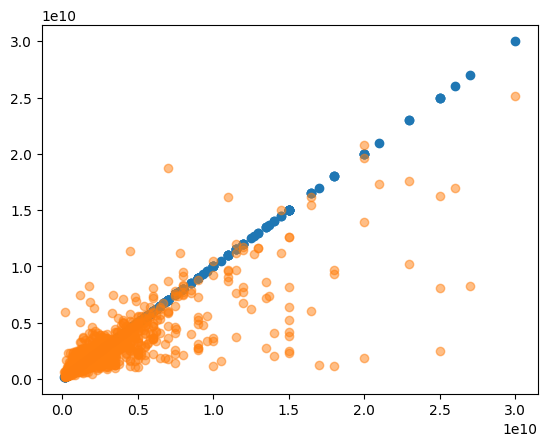

In [73]:
plt.scatter(np.expm1(y_test),np.expm1(y_test),alpha=1)
plt.scatter(np.expm1(y_test),np.expm1(y_pred),alpha=.5)

R2-Score Apartemen: 0.9342652164400381


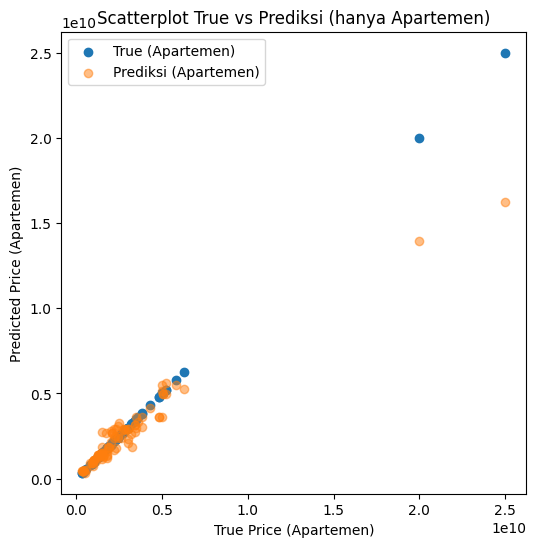

In [74]:
mask_apartemen = X_test['jenis_properti'] == 'Apartemen'

y_test_apartemen = y_test[mask_apartemen]
y_pred_apartemen = y_pred[mask_apartemen]

print(f"R2-Score Apartemen: {r2_score(y_test_apartemen,y_pred_apartemen)}")
plt.figure(figsize=(6,6))
plt.scatter(np.expm1(y_test_apartemen), np.expm1(y_test_apartemen), alpha=1, label="True (Apartemen)")
plt.scatter(np.expm1(y_test_apartemen), np.expm1(y_pred_apartemen), alpha=0.5, label="Prediksi (Apartemen)")
plt.xlabel('True Price (Apartemen)')
plt.ylabel('Predicted Price (Apartemen)')
plt.legend()
plt.title("Scatterplot True vs Prediksi (hanya Apartemen)")
plt.show()


R2-Score Rumah: 0.7913106976190961


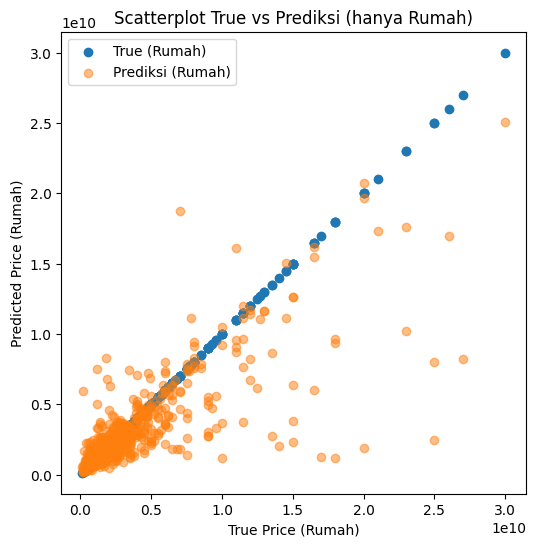

In [75]:
mask_Rumah = X_test['jenis_properti'] == 'Rumah'

y_test_Rumah = y_test[mask_Rumah]
y_pred_Rumah = y_pred[mask_Rumah]

print(f"R2-Score Rumah: {r2_score(y_test_Rumah,y_pred_Rumah)}")
plt.figure(figsize=(6,6))
plt.scatter(np.expm1(y_test_Rumah), np.expm1(y_test_Rumah), alpha=1, label="True (Rumah)")
plt.scatter(np.expm1(y_test_Rumah), np.expm1(y_pred_Rumah), alpha=0.5, label="Prediksi (Rumah)")
plt.xlabel('True Price (Rumah)')
plt.ylabel('Predicted Price (Rumah)')
plt.legend()
plt.title("Scatterplot True vs Prediksi (hanya Rumah)")
plt.show()


R2-Score Ruko: 0.605101604459986


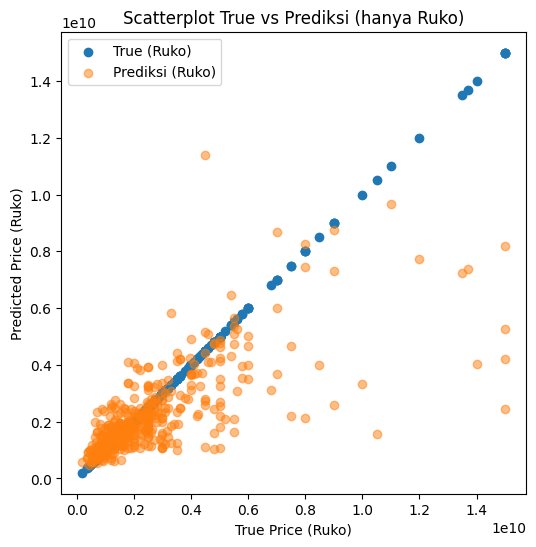

In [76]:
mask_Ruko = X_test['jenis_properti'] == 'Ruko'

y_test_Ruko = y_test[mask_Ruko]
y_pred_Ruko = y_pred[mask_Ruko]

print(f"R2-Score Ruko: {r2_score(y_test_Ruko,y_pred_Ruko)}")
plt.figure(figsize=(6,6))
plt.scatter(np.expm1(y_test_Ruko), np.expm1(y_test_Ruko), alpha=1, label="True (Ruko)")
plt.scatter(np.expm1(y_test_Ruko), np.expm1(y_pred_Ruko), alpha=0.5, label="Prediksi (Ruko)")
plt.xlabel('True Price (Ruko)')
plt.ylabel('Predicted Price (Ruko)')
plt.legend()
plt.title("Scatterplot True vs Prediksi (hanya Ruko)")
plt.show()


### MAE dan RMSE

In [77]:
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)

print(f"MAE: {mean_absolute_error(y_test_exp, y_pred_exp)}")
print(f"RMSE: {root_mean_squared_error(y_test_exp, y_pred_exp)}")

MAE: 704274162.5564736
RMSE: 1850099453.601635


In [78]:
mae = mean_absolute_error(y_test_exp, y_pred_exp)
rmse = root_mean_squared_error(y_test_exp, y_pred_exp)

# Hitung rata-rata harga asli sebagai pembanding
mean_price = np.mean(y_test_exp)

# Normalisasi error terhadap rata-rata harga (relatif error)
mae_relative = mae / mean_price
rmse_relative = rmse / mean_price

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Mean Price: {mean_price:.2f}")
print(f"Relative MAE: {mae_relative:.2%}")
print(f"Relative RMSE: {rmse_relative:.2%}")


MAE: 704274162.56
RMSE: 1850099453.60
Mean Price: 2311507438.02
Relative MAE: 30.47%
Relative RMSE: 80.04%


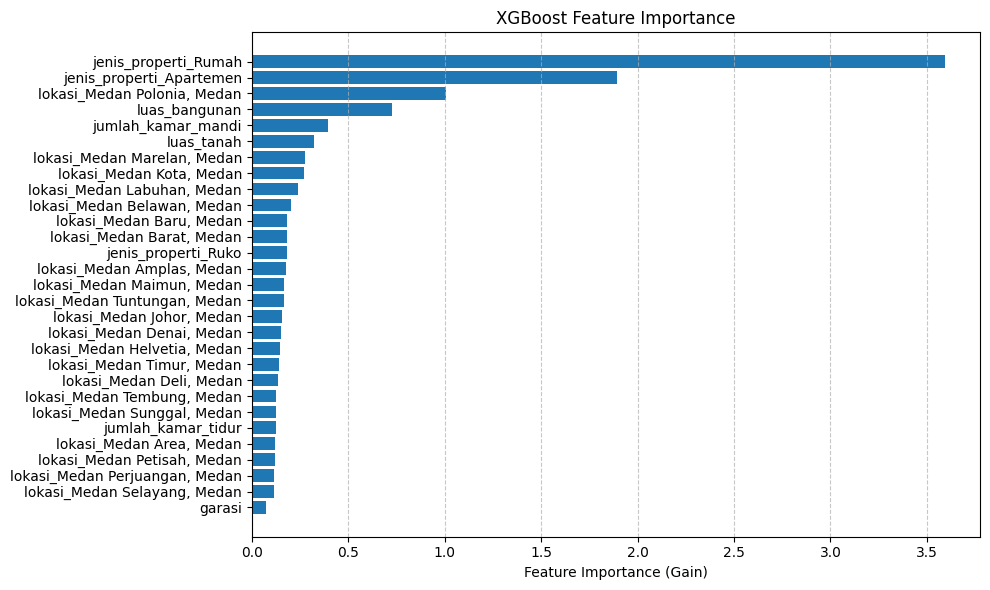

In [79]:
xgb_model_only = xgb_model_pipeline.named_steps['model']
transformer = xgb_model_pipeline.named_steps['transformer']

# Numeric features (scaler tidak mengubah nama)
numeric_features = ['jumlah_kamar_tidur', 'jumlah_kamar_mandi', 'garasi', 'luas_tanah', 'luas_bangunan']

# Ambil fitur hasil one-hot encoding
ohe = transformer.named_transformers_['one_hot']
ohe_features = ohe.get_feature_names_out(['lokasi', 'jenis_properti'])

# Gabungkan semua nama fitur akhir
feature_names = np.concatenate([numeric_features, ohe_features])

importance_dict = xgb_model_only.get_booster().get_score(importance_type='gain')

# Karena fitur dalam importance_dict pakai format 'f0', 'f1', ... kita buat mapping ke nama fitur sebenarnya
importance = []
features_mapped = []

for i in range(len(feature_names)):
    f = f'f{i}'
    if f in importance_dict:
        importance.append(importance_dict[f])
        features_mapped.append(feature_names[i])

# Sort fitur berdasarkan importance
indices = np.argsort(importance)

plt.figure(figsize=(10,6))
plt.barh(np.array(features_mapped)[indices], np.array(importance)[indices])
plt.xlabel('Feature Importance (Gain)')
plt.title('XGBoost Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
import joblib

joblib.dump(xgb_model_pipeline,"..//model//xgb_model_pipeline.pkl")

['..//model//xgb_model_pipeline.pkl']

## Insight dan Summary
- Penggunaan pipeline untuk kemudahan dalam preprocessing, training dan prediksi
- Menggunakan xgboost untuk model utama dan hyperparameter tuning dengan optuna untuk mencari hyperparameter optimal
- Setelah evaluasi, untuk model XGBoost, skor yang didapat yakni:
    - MAE: 704274162.56
    - RMSE: 1850099453.60
    - Mean Price: 2311507438.02
    - Relative MAE: 30.47%
    - Relative RMSE: 80.04%
- R2 Score untuk kategori Apartemen yang paling tinggi yakni 0.934 lalu Rumah 0.79 dan Ruko yang paling rendah 0.60
- Dari feature importances, fitur paling penting yakni jenis properti, lokasi (terutama lokasi tertentu seperti Medan Polonia), luas bangunan,dll
- Overall, model menunjukkan hasil yang lumrah untuk dataset dengan fitur seadanya yakni hanya area/kamar/lokasi tekstual. Kedepannya model dapat ditingkatkan performanya dengan mendapatkan fitur berupa alamat lengkap, peta, umur bangunan, ke-strategisan (dekat ke sekolah,dsb).
